### The goal is to create a regression model for predicting housing prices

In [1]:
# loading essential packages
import numpy as np
import pandas as pd
import wget

# loading visualization packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### Dowloading and taking a quick look at the dataset

In [2]:

data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
wget.download(data)


'housing (3).csv'

In [3]:
# Reading the dataset
df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<Axes: xlabel='median_house_value', ylabel='Count'>

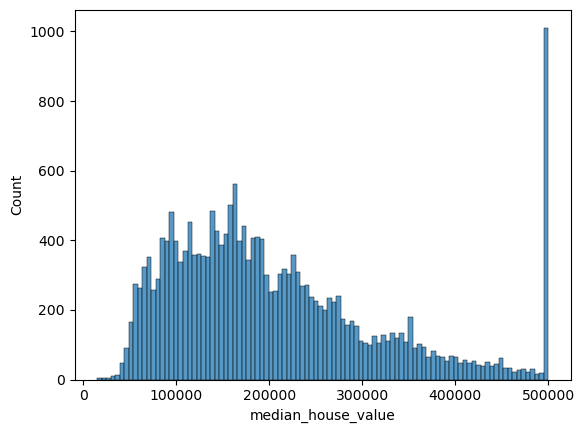

In [4]:
sns.histplot(df.median_house_value, bins = 100)

We can see it is right-skewed and has a long tail

In [5]:
df.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

Let's look at only INLAND and <1H OCEAN houses

In [6]:
df = df[df.ocean_proximity.isin(["INLAND","<1H OCEAN"])]
df.ocean_proximity.unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

In [7]:
# Include all columns except for ocean proximity
df.drop(columns=['ocean_proximity'], inplace=True)
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


Look at missing values

In [8]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

total_bedrooms has 157 missing values while the rest of the columns do not have any


In [9]:
# median (50th percentile) for population
df.population.median()

1195.0

### Data Preparation - Shuffling, splitting dataset, transforming target variable, dealing with missing values

In [10]:
# data preparation before fitting a linear regression
def prepare_X_y(df, fill_na_with_mean = False, seed = 42):

    # shuffling based on seed choice
    df = df.sample(frac=1, random_state=seed)

    # splitting dataset into train, validation and test sets
    df_train, df_val, df_test = np.split(df, [int(0.6*len(df)), int(0.8*(len(df)))])

    # transforming target variable using log to avoid skewed distribution
    df_train.median_house_value = np.log1p(df_train.median_house_value)
    df_val.median_house_value = np.log1p(df_val.median_house_value)
    df_test.median_house_value = np.log1p(df_test.median_house_value)
    
    # filling missing values with mean or zero
    if fill_na_with_mean:
        # calculating average total bedrooms from train data
        fill_value = df_train.total_bedrooms.mean()
    else:
        fill_value = 0
    
        
    df_train.total_bedrooms.fillna(fill_value, inplace=True)
    df_val.total_bedrooms.fillna(fill_value, inplace=True)
    df_test.total_bedrooms.fillna(fill_value, inplace=True)

    x_train = df_train.loc[:, df_train.columns != 'median_house_value'].values
    y_train = df_train['median_house_value'].values

    x_val = df_val.loc[:, df_val.columns != 'median_house_value'].values
    y_val = df_val['median_house_value'].values

    x_test = df_test.loc[:, df_test.columns != 'median_house_value'].values
    y_test = df_test['median_house_value'].values

    return x_train, y_train, x_val, y_val, x_test, y_test


### Filling missing values with zero

In [11]:
x_train, y_train, x_val, y_val, x_test, y_test = prepare_X_y(df, fill_na_with_mean=False, seed = 42)
len(x_train), len(y_train), len(x_val), len(y_val), len(x_test), len(y_test)

(9412, 9412, 3137, 3137, 3138, 3138)

### Linear Regression Function

In [12]:
def train_linear_regression(X, y, r=0.0):
    
    # stacking 1,1,1,1,.... before the features. This is for w0 (bias term).
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

### Training without regularization

In [13]:
# get weights
w0, w = train_linear_regression(x_train, y_train)
w0, w

(-9.760282389232469,
 array([-2.55894354e-01, -2.68175850e-01,  1.78278062e-03, -3.37898192e-05,
         2.93842680e-04, -1.52111419e-04,  3.96416869e-04,  1.80614799e-01]))

In [14]:
# get predictions when missing values were filled with 0
y_pred_0 = w0 + x_train.dot(w)
y_pred_0

array([11.48901068, 12.1484566 , 12.45850232, ..., 11.44249195,
       12.91341245, 11.93071785])

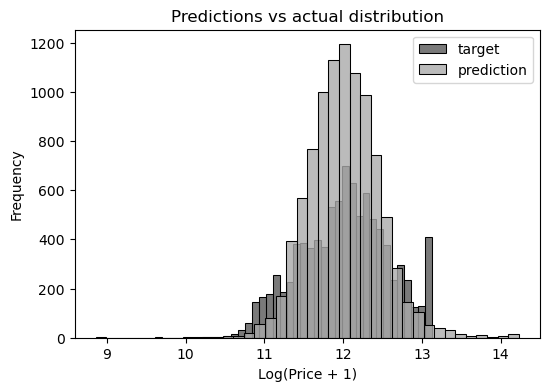

In [15]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred_0, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

### Defining evaluation metric RMSE

In [16]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [17]:
# train error
round(rmse(y_train, y_pred_0),2)

0.34

In [18]:
# get predictions when missing values were filled with 0
y_pred_0 = w0 + x_val.dot(w)
y_pred_0

# validation set error
rmse_0 = round(rmse(y_val, y_pred_0),2)
rmse_0


0.34

### Filling missing values with mean (total_bedrooms column)

In [19]:
x_train, y_train, x_val, y_val, x_test, y_test = prepare_X_y(df, fill_na_with_mean=True, seed = 42)
len(x_train), len(y_train), len(x_val), len(y_val), len(x_test), len(y_test)

(9412, 9412, 3137, 3137, 3138, 3138)

### Training without regularization

In [20]:
# get weights
w0, w = train_linear_regression(x_train, y_train)
w0, w


(-9.883233238575944,
 array([-2.56982380e-01, -2.68595357e-01,  1.80454530e-03, -3.87168461e-05,
         3.78946613e-04, -1.49559864e-04,  3.24795612e-04,  1.81966411e-01]))

In [21]:
# get predictions when missing values were filled with 0
y_pred_mean = w0 + x_train.dot(w)
y_pred_mean

array([11.48147071, 12.14192732, 12.45145429, ..., 11.4390022 ,
       12.9140339 , 11.93461481])

In [22]:
# train error
round(rmse(y_train, y_pred_mean),2)

0.34

In [23]:
# get predictions when missing values were filled with mean
y_pred_mean = w0 + x_val.dot(w)
y_pred_mean

# validation set error
rmse_mean = round(rmse(y_val, y_pred_mean),2)
rmse_mean

0.34

Filling missing values with either 0 or mean in the dataset gives us the same RMSE

### Regularized Linear Regression: Filling nas with 0

In [24]:
x_train, y_train, x_val, y_val, x_test, y_test = prepare_X_y(df, fill_na_with_mean=False, seed = 42)
len(x_train), len(y_train), len(x_val), len(y_val), len(x_test), len(y_test)

(9412, 9412, 3137, 3137, 3138, 3138)

In [25]:
regularization_parameters = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for r in regularization_parameters:

    # training with regularization
    w0, w = train_linear_regression(x_train, y_train, r = r)

    # get predictions
    y_pred = w0 + x_val.dot(w)

    # validation set error
    rmse_mean = round(rmse(y_val, y_pred),2)

    print(r, rmse_mean)


0 0.34
1e-06 0.34
0.0001 0.34
0.001 0.34
0.01 0.34
0.1 0.34
1 0.34
5 0.35
10 0.35


### Training with different seeds, without regularization, filling nas with 0

In [26]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_results = []

for value in seed_values:    

    # shuffling and splitting, filling missing values with 0
    x_train, y_train, x_val, y_val, x_test, y_test = prepare_X_y(df = df, fill_na_with_mean = False, seed = value)

    # training without regularization
    w0, w = train_linear_regression(x_train, y_train, r = 0)

    # get predictions
    y_pred = w0 + x_val.dot(w)

    # validation set error
    rmse_results.append(rmse(y_val, y_pred))

rmse_results

[0.3377846115210822,
 0.3378066543009298,
 0.33846044731881775,
 0.3320086319057813,
 0.33944492069602683,
 0.34337807814846283,
 0.33853387112813416,
 0.34814297152954615,
 0.3512727798516247,
 0.3341662373171238]

In [27]:
round(np.std(rmse_results),3)

0.006

### Combining train and validation sets

In [28]:
# shuffling and splitting, filling missing values with 0
x_train, y_train, x_val, y_val, x_test, y_test = prepare_X_y(df = df, fill_na_with_mean = False, seed = 9)

# combining train and val datasets
x_train = np.concatenate((x_train, x_val))
y_train = np.concatenate((y_train, y_val))

x_train



array([[-1.1705e+02,  3.2820e+01,  1.6000e+01, ...,  1.6840e+03,
         7.0100e+02,  4.2312e+00],
       [-1.1800e+02,  3.3910e+01,  1.9000e+01, ...,  2.3740e+03,
         7.5300e+02,  5.9790e+00],
       [-1.2196e+02,  3.7250e+01,  3.5000e+01, ...,  4.8400e+02,
         1.7400e+02,  6.1648e+00],
       ...,
       [-1.1825e+02,  3.3930e+01,  4.2000e+01, ...,  7.5400e+02,
         1.7400e+02,  2.0486e+00],
       [-1.1699e+02,  3.2850e+01,  3.2000e+01, ...,  3.0250e+03,
         9.4800e+02,  4.0931e+00],
       [-1.2268e+02,  3.8480e+01,  1.5000e+01, ...,  7.1600e+02,
         2.5900e+02,  5.3409e+00]])

### Evaluating the model with test set

In [29]:
# training regularization
w0, w = train_linear_regression(x_train, y_train, r = 0.001)

# get predictions
y_pred = w0 + x_test.dot(w)

# test set error
rmse_test = round(rmse(y_test, y_pred),2)

rmse_test

0.33